In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

from IPython.display import display

In [2]:
ANGLE_RANGE = 2*np.pi
CODE_COLOR_MAP = {0 : 'yellow',
                  1 : 'blue',
                  2 : 'purple'}

In [3]:
prob_code0_in_states = np.array([1, 0, 1, 1])
prob_code1_in_states = np.array([0, 1, 0, 0])
EMISSION_MATRIX_TARGET = np.vstack([prob_code0_in_states, prob_code1_in_states])

prob_code0_in_states = np.array([1, 1, 1, 1])
prob_code1_in_states = np.array([0, 0, 0, 0])
EMISSION_MATRIX_NONTARGET = np.vstack([prob_code0_in_states, prob_code1_in_states])

In [4]:
# prob_code0_in_states = np.array([0.5, 0.5, 0.0, 0.5, 0.0, 0.5, 0.5, 0.5])
# prob_code1_in_states = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# prob_code2_in_states = np.array([0.5, 0.5, 0.0, 0.5, 1.0, 0.5, 0.5, 0.5])
# EMISSION_MATRIX_TARGET = np.vstack([prob_code0_in_states, prob_code1_in_states, prob_code2_in_states])

# prob_code0_in_states = np.array([0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5])
# prob_code1_in_states = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# prob_code2_in_states = np.array([0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 1.0, 0.5])
# EMISSION_MATRIX_NONTARGET = np.vstack([prob_code0_in_states, prob_code1_in_states, prob_code2_in_states])

In [5]:
EMISSION_MATRIX_TARGETS = np.stack([EMISSION_MATRIX_TARGET, EMISSION_MATRIX_NONTARGET])
EMISSION_MATRIX_TARGETS, EMISSION_MATRIX_TARGETS.shape

(array([[[1, 0, 1, 1],
         [0, 1, 0, 0]],
 
        [[1, 1, 1, 1],
         [0, 0, 0, 0]]]),
 (2, 2, 4))

In [6]:
NUM_STATES = EMISSION_MATRIX_TARGETS.shape[2]
NUM_OBSERVATIONS = EMISSION_MATRIX_TARGETS.shape[1]
NUM_BELIEFS = EMISSION_MATRIX_TARGETS.shape[0]

STATE_STEP = ANGLE_RANGE/NUM_STATES
STATE_CENTERS = (np.arange(-STATE_STEP, ANGLE_RANGE-STATE_STEP, STATE_STEP) + STATE_STEP) % ANGLE_RANGE

PRIOR_TARGET_PROB = np.full(NUM_BELIEFS, 1/NUM_BELIEFS)
PRIOR_STATE_PROB = np.full(NUM_STATES, 1/NUM_STATES)
PRIOR_TARGET_PROB, PRIOR_STATE_PROB

(array([0.5, 0.5]), array([0.25, 0.25, 0.25, 0.25]))

In [7]:
CANDIDATE_STEPS = np.array([-STATE_STEP, 0, STATE_STEP])

In [8]:
EMISSION_MATRIX_TARGET[1:,:]

array([[0, 1, 0, 0]])

In [9]:
code_regions_info = dict()
regions = np.array(np.where(EMISSION_MATRIX_TARGET[1:,:]==1))
code_regions_info['states'] = regions[1,:]
code_regions_info['observations'] = regions[0,:]+1
code_regions_info['first_nonzero_state_center'] = STATE_CENTERS[code_regions_info['states']][0]
code_regions_info['last_nonzero_state_center'] = STATE_CENTERS[code_regions_info['states']][-1]
code_regions_info

{'states': array([1]),
 'observations': array([1]),
 'first_nonzero_state_center': np.float64(1.5707963267948966),
 'last_nonzero_state_center': np.float64(1.5707963267948966)}

In [10]:
code_regions_info['states']

array([1])

In [11]:
def get_deterministic_state_transition_matrix(candidate_step):
    if candidate_step!=0:
        shift = int(candidate_step / STATE_STEP)
    else:
        shift = 0

    state_matrix = np.eye(NUM_STATES)
    state_transition_matrix = np.roll(state_matrix, shift, axis=1)
    
    return state_transition_matrix

def get_deterministic_states_from_emission_matrix(emission_matrix):
   code_regions_info = dict()
   regions = np.array(np.where(emission_matrix[1:,:]==1))
   code_regions_info['states'] = regions[1,:]
   code_regions_info['observations'] = regions[0,:]+1
   code_regions_info['first_nonzero_state_center'] = STATE_CENTERS[code_regions_info['states']][0]
   code_regions_info['last_nonzero_state_center'] = STATE_CENTERS[code_regions_info['states']][-1]

   return code_regions_info

def plot_code_dependent_regions(cur_ax, emission_matrix, setup_details):
   pie = np.pi
   if (~(emission_matrix[1:]==1)).all():
      code_received = 0
      theta_obs0 = np.linspace(0, 2*pie, 30)
      x_inner = setup_details['inner_radius'] * np.cos(theta_obs0)
      y_inner =  setup_details['inner_radius'] * np.sin(theta_obs0)
      x_poly = np.concatenate([setup_details['outer_radius']*x_inner, x_inner[::-1]])
      y_poly = np.concatenate([setup_details['outer_radius']*y_inner, y_inner[::-1]])
      cur_ax.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
      cur_ax.plot(x_inner, y_inner, color='orange', linewidth=1)
   else:
      code_regions_info = get_deterministic_states_from_emission_matrix(emission_matrix)
      theta_obs0 = np.linspace(0, code_regions_info['first_nonzero_state_center'] - (STATE_STEP/2), 30)
      x_inner = setup_details['inner_radius'] * np.cos(theta_obs0)
      y_inner =  setup_details['inner_radius'] * np.sin(theta_obs0)
      x_poly = np.concatenate([setup_details['outer_radius']*x_inner, x_inner[::-1]])
      y_poly = np.concatenate([setup_details['outer_radius']*y_inner, y_inner[::-1]])
      cur_ax.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
      cur_ax.plot(x_inner, y_inner, color='orange', linewidth=1)

      code_received = 0
      for i, state_c in enumerate(STATE_CENTERS[code_regions_info['states']]):
         if setup_details['agent_radians'] > (state_c - (STATE_STEP/2)) and setup_details['agent_radians'] < (state_c + (STATE_STEP/2)):
            code_received = code_regions_info['observations'][i]
         theta_obs_not0 = np.linspace(state_c - (STATE_STEP/2), state_c + (STATE_STEP/2), 30)
         x_inner = setup_details['inner_radius'] * np.cos(theta_obs_not0)
         y_inner =  setup_details['inner_radius'] * np.sin(theta_obs_not0)
         x_poly = np.concatenate([setup_details['outer_radius']*x_inner, x_inner[::-1]])
         y_poly = np.concatenate([setup_details['outer_radius']*y_inner, y_inner[::-1]])
         cur_ax.fill(x_poly, y_poly, facecolor=CODE_COLOR_MAP[code_regions_info['observations'][i]], alpha=0.25, linewidth=0)
         cur_ax.plot(x_inner, y_inner, color=CODE_COLOR_MAP[code_regions_info['observations'][i]], linewidth=1)
         
         if i < code_regions_info['states'].shape[0]-1:
            theta_obs0 = np.linspace(state_c + (STATE_STEP/2), STATE_CENTERS[code_regions_info['states']][i+1] - (STATE_STEP/2), 30)
            x_inner = setup_details['inner_radius'] * np.cos(theta_obs0)
            y_inner =  setup_details['inner_radius'] * np.sin(theta_obs0)
            x_poly = np.concatenate([setup_details['outer_radius']*x_inner, x_inner[::-1]])
            y_poly = np.concatenate([setup_details['outer_radius']*y_inner, y_inner[::-1]])
            cur_ax.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
            cur_ax.plot(x_inner, y_inner, color='orange', linewidth=1)

      theta_obs0 = np.linspace(code_regions_info['last_nonzero_state_center'] + (STATE_STEP/2), 2*pie, 30)
      x_inner = setup_details['inner_radius'] * np.cos(theta_obs0)
      y_inner =  setup_details['inner_radius'] * np.sin(theta_obs0)
      x_poly = np.concatenate([setup_details['outer_radius']*x_inner, x_inner[::-1]])
      y_poly = np.concatenate([setup_details['outer_radius']*y_inner, y_inner[::-1]])
      cur_ax.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
      cur_ax.plot(x_inner, y_inner, color='orange', linewidth=1)

   return code_received

def plot_agent_in_env(cur_ax, setup_details, code_received):
   for theta in STATE_CENTERS:
      r_outer = 4 * setup_details['outer_radius']
      cur_ax.plot([setup_details['inner_radius']*np.cos(theta), r_outer*np.cos(theta)], 
               [setup_details['inner_radius']*np.sin(theta), r_outer*np.sin(theta)],
                  color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
      
   initial_state = np.floor((setup_details['agent_radians'] + (STATE_STEP/2)) / STATE_STEP) % NUM_STATES
   cur_ax.scatter(setup_details['outer_radius']*np.cos(STATE_CENTERS[int(initial_state)]), setup_details['outer_radius']*np.sin(STATE_CENTERS[int(initial_state)]),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}')
   cur_ax.set_title(f'{setup_details["title"]} Model')
   cur_ax.set_aspect('equal', adjustable='box')
   cur_ax.set_xticks([])
   cur_ax.set_yticks([])
   cur_ax.set_xlim(-setup_details['grid_extent'], setup_details['grid_extent'])
   cur_ax.set_ylim(-setup_details['grid_extent'], setup_details['grid_extent'])
   cur_ax.legend()

def plot_agent_env_setup(cur_ax, emission_matrix, setup_details):
   code_received = plot_code_dependent_regions(cur_ax, emission_matrix, setup_details)
   plot_agent_in_env(cur_ax, setup_details, code_received)

def observe_angle_state_pair(initial_angle):
   initial_radians = np.radians((initial_angle % 360))

   fig, ax = plt.subplots(1, 2, figsize=(12, 6))
   setup_details = {'title': 'Target', 'grid_extent': 10, 
                    'inner_radius' : 1, 'outer_radius' : 5,
                    'agent_radians' : initial_radians}
   plot_agent_env_setup(ax[0], EMISSION_MATRIX_TARGETS[0], setup_details)

   setup_details['title'] = 'Non-Target'
   plot_agent_env_setup(ax[1], EMISSION_MATRIX_TARGETS[1], setup_details)
   
   plt.show()


In [12]:
initial_angle_slider = widgets.IntSlider(
    value=0,  
    min=0,
    max=360,
    description="Initial Angle",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="600px"),
)

interactive_plot = widgets.interactive(
    observe_angle_state_pair, initial_angle=initial_angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Initial Angle', layout=Layout(width='600px'), max=360, s…

In [13]:
candidate_step = -STATE_STEP
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [14]:
candidate_step = 0
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [15]:
candidate_step = STATE_STEP
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [63]:
def move_and_sample_from_object(within_trial_arrays, trial_params, emission_matrix_true):
    if trial_params["time_ind"]<1:
        within_trial_arrays['angles_visited'][trial_params["time_ind"]] = trial_params["initial_angle"]
    else:
        within_trial_arrays['angles_visited'][trial_params["time_ind"]] = within_trial_arrays['angles_visited'][trial_params["time_ind"]-1] + np.rad2deg(within_trial_arrays['steps_taken'][int(trial_params["time_ind"]-1)])

    angle_visited_radians = np.radians((within_trial_arrays['angles_visited'][trial_params["time_ind"]] % 360))
    state_visited = np.floor((angle_visited_radians) / STATE_STEP)
    within_trial_arrays['code_received_t'][trial_params["time_ind"]] = np.random.choice(np.arange(NUM_OBSERVATIONS), p=emission_matrix_true[:,int(state_visited)])

def bayes_update(numerator):
    denominator = numerator.sum()
    if denominator > 0:
        return numerator / denominator
    else:
        return numerator
    
def update_posterior_and_compute_current_entropy(within_trial_arrays, trial_params, emission_matrix_targets):
    if trial_params["time_ind"]<1:
        within_trial_arrays["joint_prob_received_obs_state_t_from_targets"][trial_params["time_ind"]] = PRIOR_STATE_PROB * emission_matrix_targets[:,int(within_trial_arrays['code_received_t'][trial_params["time_ind"]])]
    else:
        state_transition_matrix = get_deterministic_state_transition_matrix(within_trial_arrays['steps_taken'][int(trial_params["time_ind"]-1)])
        prob_of_received_obs_from_states_given_targets = emission_matrix_targets[:,int(within_trial_arrays['code_received_t'][trial_params["time_ind"]])]
        joint_prob_of_previous_obs_from_states = within_trial_arrays['joint_prob_received_obs_state_t_from_targets'][trial_params["time_ind"]-1]
        within_trial_arrays['joint_prob_received_obs_state_t_from_targets'][trial_params["time_ind"]] = (joint_prob_of_previous_obs_from_states @ state_transition_matrix) * prob_of_received_obs_from_states_given_targets

    within_trial_arrays['likelihood_received_obs_from_targets_t'][trial_params["time_ind"]] = within_trial_arrays['joint_prob_received_obs_state_t_from_targets'][trial_params["time_ind"]].sum(axis=1)

    if trial_params["time_ind"]<1:
        likelihood_received_obs = within_trial_arrays['likelihood_received_obs_from_targets_t'][trial_params["time_ind"]]
        within_trial_arrays['posterior_t'][trial_params["time_ind"]] = bayes_update(PRIOR_TARGET_PROB*likelihood_received_obs)
    else:
        likelihood_received_obs_given_observed_sequence = update_likelihood_given_observed_sequence(within_trial_arrays['likelihood_received_obs_from_targets_t'][trial_params["time_ind"]], within_trial_arrays['likelihood_received_obs_from_targets_t'][trial_params["time_ind"]-1])
        within_trial_arrays['posterior_t'][trial_params["time_ind"]] = bayes_update(within_trial_arrays['posterior_t'][trial_params["time_ind"]-1]*likelihood_received_obs_given_observed_sequence)

    within_trial_arrays['current_entropyS_t'][trial_params["time_ind"]] = compute_entropy_from_posterior_across_targets(within_trial_arrays['posterior_t'][trial_params["time_ind"]])

def debug_within_trial_print_statements(within_trial_arrays, trial_params):
    for target_t in range(NUM_BELIEFS):
        if int(trial_params["time_ind"]+1)>1:
            obs_string = f'O1:{int(trial_params["time_ind"]+1)}={within_trial_arrays['code_received_t'][:int(trial_params["time_ind"]+1)]}'
        else:
            obs_string = f'O1={within_trial_arrays['code_received_t'][:int(trial_params["time_ind"]+1)]}'

        if int(trial_params["time_ind"]+1)>2:
            angle_steps_string = f'Δθ2:{int(trial_params["time_ind"]+1)}'
        else:
            angle_steps_string = f'Δθ2'

        joint_prob_term_val = within_trial_arrays["joint_prob_received_obs_state_t_from_targets"][trial_params["time_ind"], target_t]
        if int(trial_params["time_ind"]+1)>1:
            joint_prob_term_name = f'P({obs_string},S{int(trial_params["time_ind"]+1)}|{angle_steps_string},T{int(target_t+1)})'
        else:
            joint_prob_term_name = f'P({obs_string},S{int(trial_params["time_ind"]+1)}|T{int(target_t+1)})'
        joint_prob_string = f'{joint_prob_term_name}={joint_prob_term_val.round(4)}'

        likelihood_of_obs_term_val = within_trial_arrays["likelihood_received_obs_from_targets_t"][trial_params["time_ind"], target_t]
        if int(trial_params["time_ind"]+1)>1:
            likelihood_of_obs_term_name = f'P({obs_string}|{angle_steps_string},T{int(target_t+1)})'
        else:
            likelihood_of_obs_term_name = f'P({obs_string}|T{int(target_t+1)})'
        likelihood_of_obs_string = f'{likelihood_of_obs_term_name}={likelihood_of_obs_term_val}'

        if int(trial_params["time_ind"]+1)>1:
            if likelihood_of_obs_term_val>0:
                state_belief_term_name = f'P(S{int(trial_params["time_ind"]+1)}|{obs_string},{angle_steps_string},T{int(target_t+1)})'
                state_belief_string = f'{state_belief_term_name}={(joint_prob_term_val/likelihood_of_obs_term_val).round(2)}'
            else:
                state_belief_term_name = f'P(S{int(trial_params["time_ind"]+1)}|{obs_string},{angle_steps_string},T{int(target_t+1)})'
                state_belief_string = f'{state_belief_term_name}={(joint_prob_term_val).round(2)}'
        else:
            if likelihood_of_obs_term_val>0:
                state_belief_term_name = f'P(S{int(trial_params["time_ind"]+1)}|{obs_string},T{int(target_t+1)})'
                state_belief_string = f'{state_belief_term_name}={(joint_prob_term_val/likelihood_of_obs_term_val).round(2)}'
            else:
                state_belief_term_name = f'P(S{int(trial_params["time_ind"]+1)}|{obs_string},T{int(target_t+1)})'
                state_belief_string = f'{state_belief_term_name}={(joint_prob_term_val).round(2)}'
        
        if int(trial_params["time_ind"]+1)>1:
            target_belief_term_name = f'P(T|{obs_string},{angle_steps_string})'
        else:
            target_belief_term_name = f'P(T|{obs_string})'
        target_belief_string = f'{target_belief_term_name}={within_trial_arrays["posterior_t"][trial_params["time_ind"]]}'

        current_entropy_term_name = f'H{int(trial_params["time_ind"]+1)}'
        current_entropy_string = f'{current_entropy_term_name}={within_trial_arrays["current_entropyS_t"][trial_params["time_ind"]]:.2f}'
        print(f'{joint_prob_string}, {likelihood_of_obs_string}, {state_belief_string}, {target_belief_string}, {current_entropy_string}')

def debug_forecasting_each_obs_print_statements(within_trial_arrays, trial_params):
    likelihood_obs_from_target_forecast_t_fromtargets = within_trial_arrays['joint_prob_received_obs_state_forecast_t_fromtargets'][trial_params["time_ind"]].sum(axis=1)
    forecasted_obs_string = f'O{int(trial_params["time_ind"]+2)}={within_trial_arrays['forecasted_obs']}'

    if int(trial_params["time_ind"]+1)>1:
        up_to_date_obs_sequence_term_name = f'O1:{int(trial_params["time_ind"]+1)}'
    else:
        up_to_date_obs_sequence_term_name = f'O1'
    up_to_date_obs_sequence_string = f'{up_to_date_obs_sequence_term_name}={within_trial_arrays['code_received_t'][:int(trial_params["time_ind"]+1)]}'

    if int(trial_params["time_ind"]+1)>1:
        angle_steps_string = f'Δθ2:{int(trial_params["time_ind"]+1)}'
    else:
        angle_steps_string = f'Δθ2'

    print(f'P({forecasted_obs_string},{up_to_date_obs_sequence_string}|{angle_steps_string},T)={likelihood_obs_from_target_forecast_t_fromtargets}')
    print(f'P({forecasted_obs_string}|{up_to_date_obs_sequence_string},{angle_steps_string},T)={within_trial_arrays['likelihood_obs_forecast_t_given_received_obs']}')

def update_likelihood_given_observed_sequence(obs_sequence_including_forecast_from_targets, obs_sequence_excluding_forecast_from_targets):
    if (obs_sequence_excluding_forecast_from_targets>0).all():
        likelihood_obs_forecast_t_given_received_obs = obs_sequence_including_forecast_from_targets / obs_sequence_excluding_forecast_from_targets
    else:
        likelihood_obs_forecast_t_given_received_obs = np.zeros(NUM_BELIEFS)
        for target_t in range(NUM_BELIEFS):
            obs_sequence_including_forecast_from_target_t = obs_sequence_including_forecast_from_targets[target_t]
            obs_sequence_excluding_forecast_from_target_t = obs_sequence_excluding_forecast_from_targets[target_t]
            if (obs_sequence_excluding_forecast_from_target_t > 0):
                likelihood_obs_from_target_forecast_t_given_received_obs_fromtarget = obs_sequence_including_forecast_from_target_t / obs_sequence_excluding_forecast_from_target_t
            else:
                likelihood_obs_from_target_forecast_t_given_received_obs_fromtarget = obs_sequence_including_forecast_from_target_t
            likelihood_obs_forecast_t_given_received_obs[target_t] = likelihood_obs_from_target_forecast_t_given_received_obs_fromtarget
    
    return likelihood_obs_forecast_t_given_received_obs

def compute_entropy_from_posterior_across_targets(posterior):
    forecasted_S_from_obs = 0
    for target_t in range(NUM_BELIEFS):
        if posterior[target_t] > 0:
            forecasted_S_from_obs += (-posterior[target_t] * np.log2(posterior[target_t]))
    return forecasted_S_from_obs

def compute_forecasted_entropy_from_forecasted_obs(within_trial_arrays, trial_params, state_transition_matrix, emission_matrix_targets):
    forecasted_S = np.zeros(NUM_OBSERVATIONS)
    prob_obs_at_forecast_t_given_obs_at_cur_t = np.zeros(NUM_OBSERVATIONS)
    posterior_forecast_given_received_obs = np.zeros((NUM_OBSERVATIONS, NUM_BELIEFS))
    for obs in range(NUM_OBSERVATIONS):
        within_trial_arrays['joint_prob_received_obs_state_forecast_t_fromtargets'][trial_params["time_ind"]] = (within_trial_arrays['joint_prob_received_obs_state_t_from_targets'][trial_params["time_ind"]] @ state_transition_matrix) * emission_matrix_targets[:,obs]
        likelihood_obs_from_target_forecast_t_fromtargets = within_trial_arrays['joint_prob_received_obs_state_forecast_t_fromtargets'][trial_params["time_ind"]].sum(axis=1)
        likelihood_obs_forecast_t_given_received_obs = update_likelihood_given_observed_sequence(likelihood_obs_from_target_forecast_t_fromtargets, within_trial_arrays['likelihood_received_obs_from_targets_t'][trial_params["time_ind"]])

        within_trial_arrays['forecasted_obs'] = obs
        within_trial_arrays['likelihood_obs_forecast_t_given_received_obs'] = likelihood_obs_forecast_t_given_received_obs
        debug_forecasting_each_obs_print_statements(within_trial_arrays, trial_params)
        
        numerator = (within_trial_arrays['posterior_t'][trial_params["time_ind"]] * likelihood_obs_forecast_t_given_received_obs)
        prob_obs_at_forecast_t_given_obs_at_cur_t[obs] = numerator.sum()
        posterior_forecast_given_received_obs[obs] = bayes_update(numerator)
        forecasted_S[obs] = compute_entropy_from_posterior_across_targets(posterior_forecast_given_received_obs[obs])

    return prob_obs_at_forecast_t_given_obs_at_cur_t, forecasted_S

def print_debug_forecasted_entropy_statements(prob_obs_at_forecast_t_given_obs_at_cur_t, forecasted_S, trial_params):
    expected_forecast_t_S = (forecasted_S * prob_obs_at_forecast_t_given_obs_at_cur_t).sum()
    print_string = f'S{int(trial_params["time_ind"]+2)} = '
    for obs in range(NUM_OBSERVATIONS):
        if obs < NUM_OBSERVATIONS - 1:
            print_string += f'{prob_obs_at_forecast_t_given_obs_at_cur_t[obs]:.3f}x{forecasted_S[obs]:.3f} + '
        else:
            print_string += f'{prob_obs_at_forecast_t_given_obs_at_cur_t[obs]:.3f}x{forecasted_S[obs]:.3f}'
    print_string += f' = {expected_forecast_t_S}'
    print(print_string)

def forecast_and_compute_expected_entropy_from_actions(within_trial_arrays, trial_params, emission_matrix_targets):
    for i, forecast_t_candidate_step in enumerate(CANDIDATE_STEPS):
        state_transition_matrix = (get_deterministic_state_transition_matrix(forecast_t_candidate_step))
        prob_obs_at_forecast_t_given_obs_at_cur_t, forecasted_S = compute_forecasted_entropy_from_forecasted_obs(within_trial_arrays, trial_params, state_transition_matrix, emission_matrix_targets)
        expected_forecast_t_S = (forecasted_S * prob_obs_at_forecast_t_given_obs_at_cur_t).sum()
        print_debug_forecasted_entropy_statements(prob_obs_at_forecast_t_given_obs_at_cur_t, forecasted_S, trial_params)
        within_trial_arrays['expected_forecast_t_S_per_step'][trial_params["time_ind"], i] = expected_forecast_t_S

def determine_decision_from_forecasted_entropy_change(within_trial_arrays, trial_params):
    unique, counts = np.unique(within_trial_arrays['deltaS_t'][trial_params['time_ind']], return_counts=True)
    frequent_cond = counts>1
    unique_frequent_delta_S = unique[frequent_cond]
    if (counts[unique==within_trial_arrays['deltaS_t'][trial_params['time_ind']].max()]==1).all():
        print('Choosing according to max ΔS')
        within_trial_arrays['decision_type_t'][trial_params['time_ind']] = 'max ΔS'
        step_to_take = CANDIDATE_STEPS[within_trial_arrays['deltaS_t'][trial_params['time_ind']].argmax()]
    else:
        print(f'DETERMINING DECISION {within_trial_arrays["posterior_t"][trial_params['time_ind']]}: {(1 in within_trial_arrays["posterior_t"][trial_params['time_ind']])}')
        if (1 not in within_trial_arrays['posterior_t'][trial_params['time_ind']]):
            print(f'Choosing randomly between {CANDIDATE_STEPS[np.where(within_trial_arrays["deltaS_t"][trial_params['time_ind']]==unique_frequent_delta_S.max())[0]]}')
            within_trial_arrays['decision_type_t'][trial_params['time_ind']] = 'random'
            step_to_take = CANDIDATE_STEPS[np.random.choice(np.where(within_trial_arrays['deltaS_t'][trial_params['time_ind']]==unique_frequent_delta_S.max())[0])]
        else:
            print('DECISION REACHED')
            within_trial_arrays['decision_type_t'][trial_params['time_ind']] = 'end'
            step_to_take = 0

    return step_to_take

In [64]:
trial_params = dict()
trial_params['trial_num'] = 0
trial_params['num_trials'] = 10
trial_params['max_iter'] = 50

across_trial_arrays = dict()
across_trial_arrays['posterior_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter']+1, NUM_BELIEFS))
across_trial_arrays['expected_forecast_t_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter'], CANDIDATE_STEPS.shape[0]))
across_trial_arrays['decision_type_across_trials'] = np.empty((trial_params['num_trials'], trial_params['max_iter']), dtype=np.dtypes.StringDType())
across_trial_arrays['angles_visited_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter']))
across_trial_arrays['steps_taken_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter']))
across_trial_arrays['entropy_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter']))
across_trial_arrays['time_taken_per_trial'] = np.zeros(trial_params['num_trials'])
across_trial_arrays['codes_received_across_trials'] = np.zeros((trial_params['num_trials'], trial_params['max_iter']))

emission_matrix_true = EMISSION_MATRIX_TARGETS[0]

while trial_params['trial_num'] < trial_params['num_trials']:
    within_trial_arrays = dict()
    within_trial_arrays['joint_prob_obs_state_t_from_targets'] = np.zeros((trial_params['max_iter'], NUM_BELIEFS, NUM_OBSERVATIONS, NUM_STATES))
    within_trial_arrays['joint_prob_received_obs_state_t_from_targets'] = np.zeros((trial_params['max_iter'], NUM_BELIEFS, NUM_STATES))
    within_trial_arrays['joint_prob_received_obs_state_forecast_t_fromtargets'] = np.zeros((trial_params['max_iter'], NUM_BELIEFS, NUM_STATES))
    within_trial_arrays['likelihood_received_obs_from_targets_t'] = np.zeros((trial_params['max_iter'], NUM_BELIEFS))

    within_trial_arrays['angles_visited'] = np.zeros(trial_params['max_iter'])
    within_trial_arrays['steps_taken'] = np.zeros(trial_params['max_iter'])
    within_trial_arrays['posterior_t'] = np.zeros((trial_params['max_iter'], NUM_BELIEFS))
    within_trial_arrays['current_entropyS_t'] = np.zeros(trial_params['max_iter'])
    
    within_trial_arrays['expected_forecast_t_S_per_step'] = np.zeros((trial_params['max_iter'], CANDIDATE_STEPS.shape[0]))
    within_trial_arrays['deltaS_t'] = np.zeros((trial_params['max_iter'], CANDIDATE_STEPS.shape[0]))
    within_trial_arrays['code_received_t'] = np.zeros(trial_params['max_iter'])
    within_trial_arrays['decision_type_t'] = np.empty(trial_params['max_iter'], dtype=np.dtypes.StringDType())

    trial_params["time_ind"] = 0
    trial_params["initial_angle"] = 0
    trial_params['stopping_num'] = 0

    while trial_params["time_ind"]<trial_params['max_iter'] and trial_params['stopping_num'] < 2:
        if np.isclose(within_trial_arrays['posterior_t'][trial_params["time_ind"]-1], 1, atol=1e-2).any() or trial_params['stopping_num']>0:
            trial_params['stopping_num']+=1

        move_and_sample_from_object(within_trial_arrays, trial_params, emission_matrix_true)
        print(f'Current angle: {within_trial_arrays["angles_visited"][trial_params["time_ind"]]}, Code received: {within_trial_arrays["code_received_t"][trial_params["time_ind"]]}')

        update_posterior_and_compute_current_entropy(within_trial_arrays, trial_params, EMISSION_MATRIX_TARGETS)

        debug_within_trial_print_statements(within_trial_arrays, trial_params)

        forecast_and_compute_expected_entropy_from_actions(within_trial_arrays, trial_params, EMISSION_MATRIX_TARGETS)

        within_trial_arrays['deltaS_t'][trial_params["time_ind"]] = within_trial_arrays['current_entropyS_t'][trial_params["time_ind"]] - within_trial_arrays['expected_forecast_t_S_per_step'][trial_params["time_ind"]]
        print(f'S{int(trial_params["time_ind"]+1)}={within_trial_arrays['current_entropyS_t'][trial_params["time_ind"]]}, S{int(trial_params["time_ind"]+2)}={within_trial_arrays['expected_forecast_t_S_per_step'][trial_params["time_ind"]]}, ΔS{int(trial_params["time_ind"]+1)}→{int(trial_params["time_ind"]+2)}={within_trial_arrays['deltaS_t'][trial_params["time_ind"]]}')

        step_to_take = determine_decision_from_forecasted_entropy_change(within_trial_arrays, trial_params)
        within_trial_arrays['steps_taken'][trial_params["time_ind"]] = step_to_take
        trial_params["time_ind"]+=1

    across_trial_arrays['posterior_across_trials'][trial_params['trial_num'],:trial_params["time_ind"]+1,:] = np.vstack([PRIOR_TARGET_PROB, within_trial_arrays['posterior_t'][:trial_params["time_ind"]]])
    across_trial_arrays['entropy_across_trials'][trial_params['trial_num'], :trial_params["time_ind"]] = within_trial_arrays['current_entropyS_t'][:trial_params["time_ind"]]
    across_trial_arrays['expected_forecast_t_across_trials'][trial_params['trial_num'], :trial_params["time_ind"],:] = within_trial_arrays['expected_forecast_t_S_per_step'][:trial_params["time_ind"]]
    across_trial_arrays['steps_taken_across_trials'][trial_params['trial_num'],          :] = within_trial_arrays['steps_taken']
    across_trial_arrays['angles_visited_across_trials'][trial_params['trial_num'],       :] = within_trial_arrays['angles_visited']
    across_trial_arrays['codes_received_across_trials'][trial_params['trial_num'],       :] = within_trial_arrays['code_received_t']
    across_trial_arrays['time_taken_per_trial'][trial_params['trial_num']] = trial_params["time_ind"]
    across_trial_arrays['decision_type_across_trials'][trial_params['trial_num']] = within_trial_arrays["decision_type_t"]
    trial_params['trial_num']+=1

Current angle: 0.0, Code received: 0.0
P(O1=[0.],S1|T1)=[0.25 0.   0.25 0.25], P(O1=[0.]|T1)=0.75, P(S1|O1=[0.],T1)=[0.33 0.   0.33 0.33], P(T|O1=[0.])=[0.42857143 0.57142857], H1=0.99
P(O1=[0.],S1|T2)=[0.25 0.25 0.25 0.25], P(O1=[0.]|T2)=1.0, P(S1|O1=[0.],T2)=[0.25 0.25 0.25 0.25], P(T|O1=[0.])=[0.42857143 0.57142857], H1=0.99
P(O2=0,O1=[0.]|Δθ2,T)=[0.5 1. ]
P(O2=0|O1=[0.],Δθ2,T)=[0.66666667 1.        ]
P(O2=1,O1=[0.]|Δθ2,T)=[0.25 0.  ]
P(O2=1|O1=[0.],Δθ2,T)=[0.33333333 0.        ]
S2 = 0.857x0.918 + 0.143x0.000 = 0.7871107149038481
P(O2=0,O1=[0.]|Δθ2,T)=[0.75 1.  ]
P(O2=0|O1=[0.],Δθ2,T)=[1. 1.]
P(O2=1,O1=[0.]|Δθ2,T)=[0. 0.]
P(O2=1|O1=[0.],Δθ2,T)=[0. 0.]
S2 = 1.000x0.985 + 0.000x0.000 = 0.9852281360342515
P(O2=0,O1=[0.]|Δθ2,T)=[0.5 1. ]
P(O2=0|O1=[0.],Δθ2,T)=[0.66666667 1.        ]
P(O2=1,O1=[0.]|Δθ2,T)=[0.25 0.  ]
P(O2=1|O1=[0.],Δθ2,T)=[0.33333333 0.        ]
S2 = 0.857x0.918 + 0.143x0.000 = 0.7871107149038481
S1=0.9852281360342515, S2=[0.78711071 0.98522814 0.78711071], ΔS1→2=[0.198

In [65]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from pathlib import Path

In [66]:
save_folder = Path(f'../test_trials__detection_model5_20251114_132700_eight_states')
save_folder.mkdir(parents=True, exist_ok=True)

In [67]:
np.repeat(across_trial_arrays['angles_visited_across_trials'][0,:int(across_trial_arrays['time_taken_per_trial'][0])], 2)

array([   0.,    0.,  -90.,  -90., -180., -180., -270., -270., -270.,
       -270., -270., -270.])

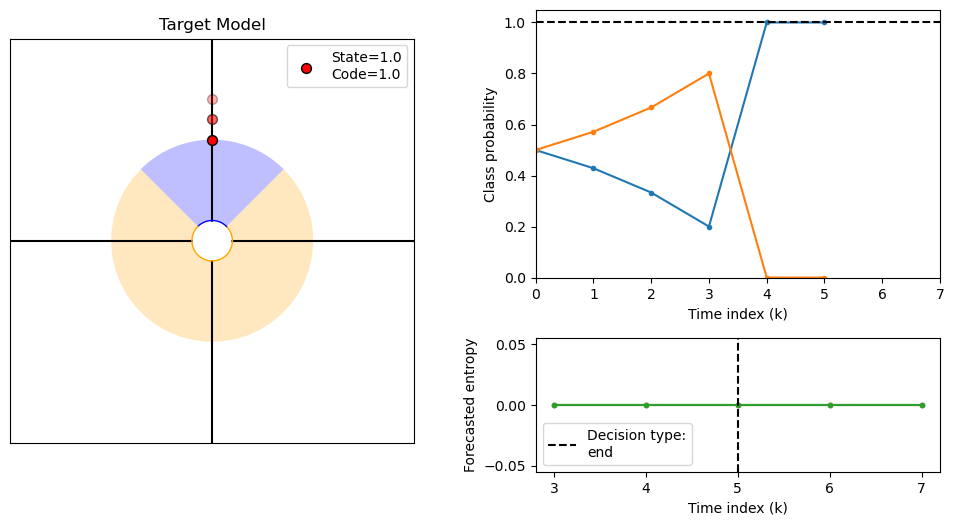

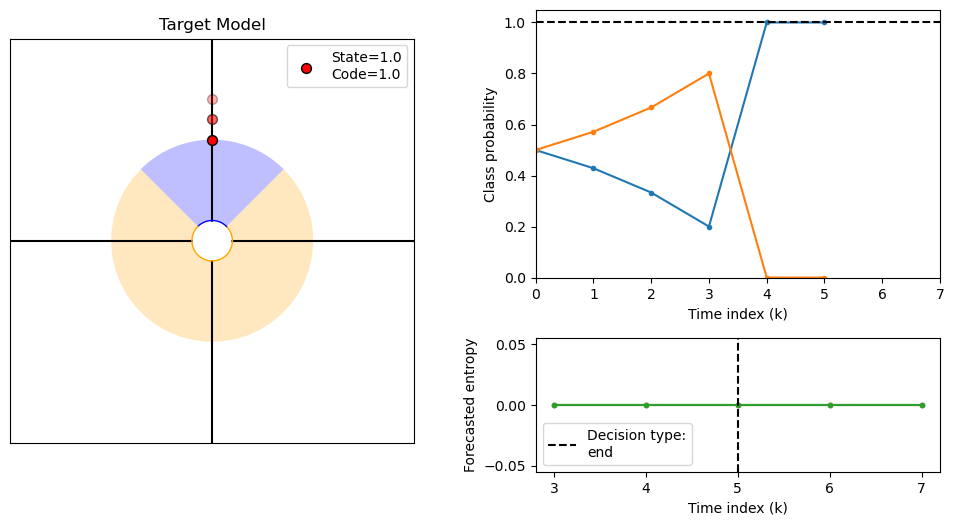

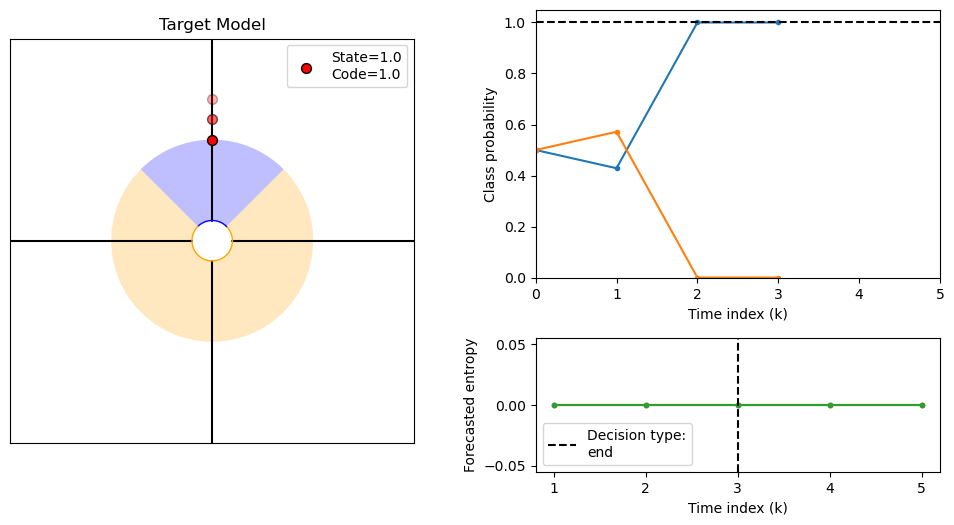

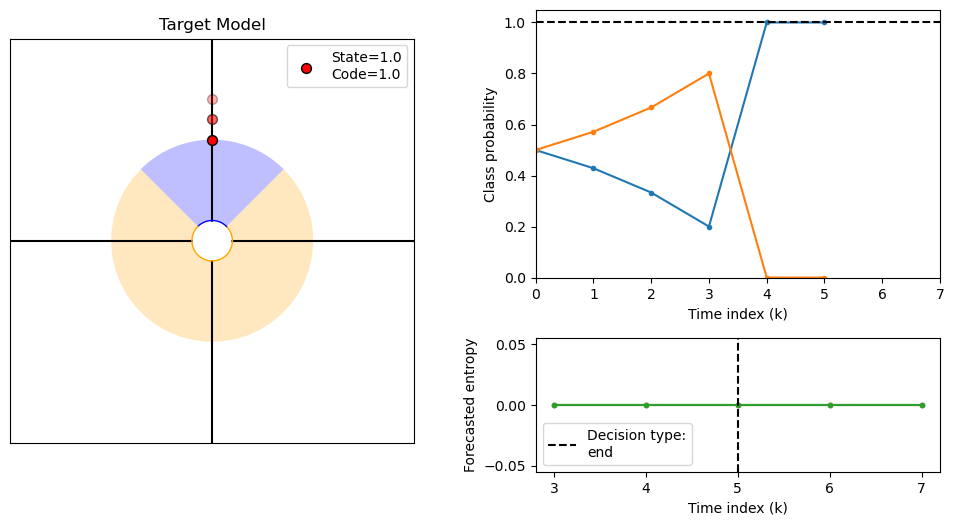

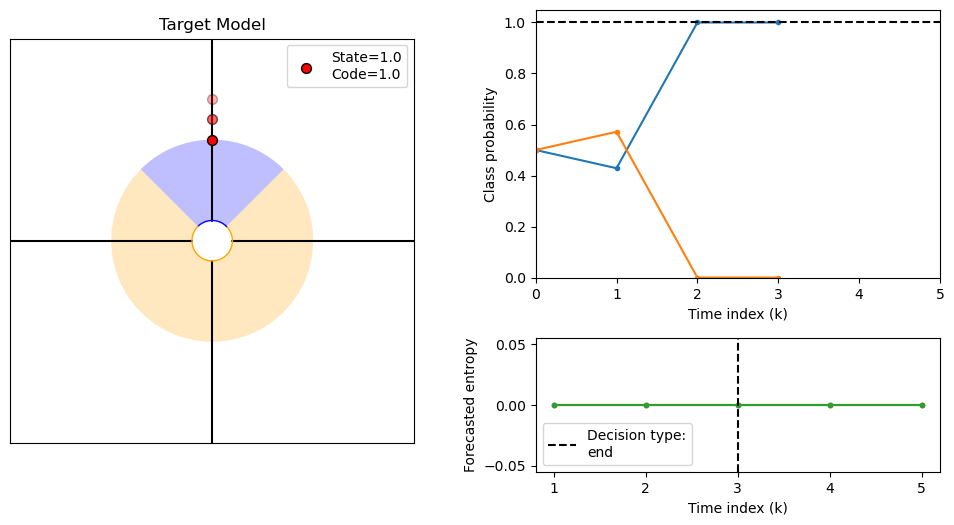

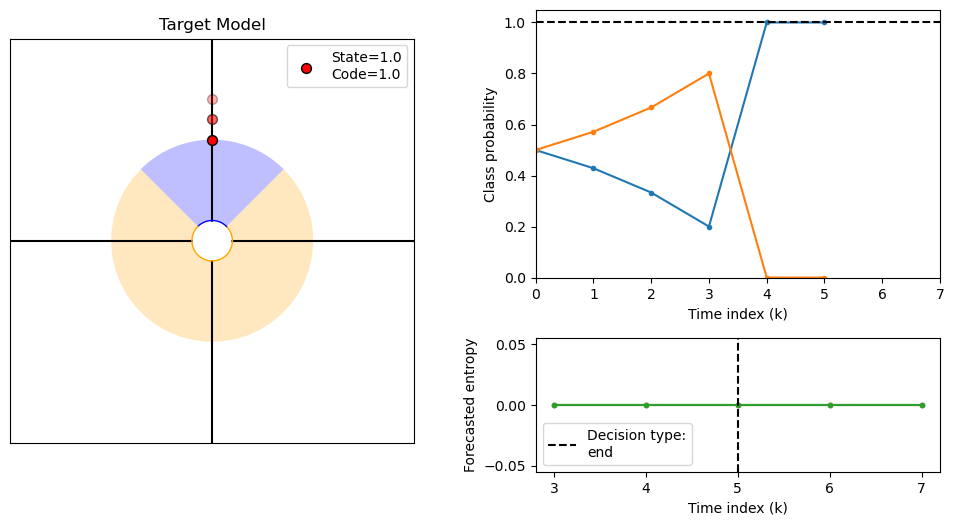

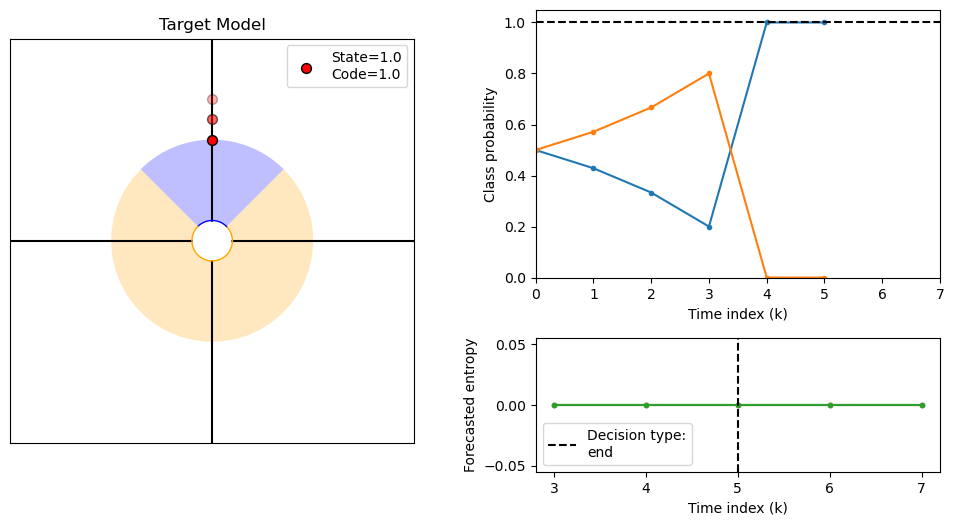

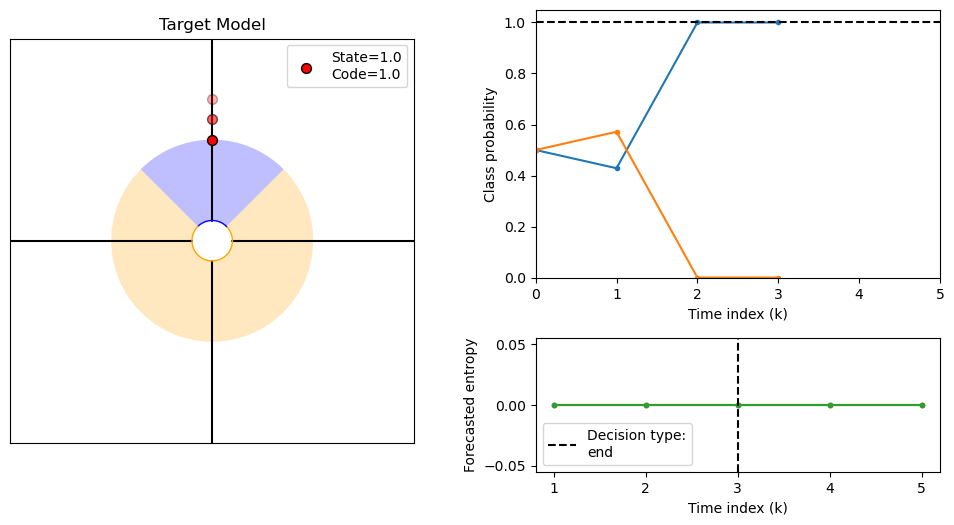

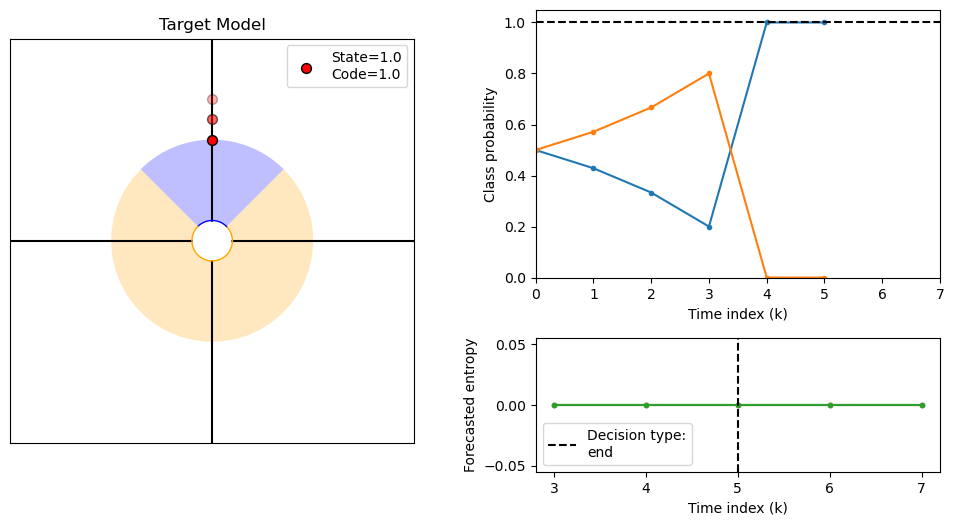

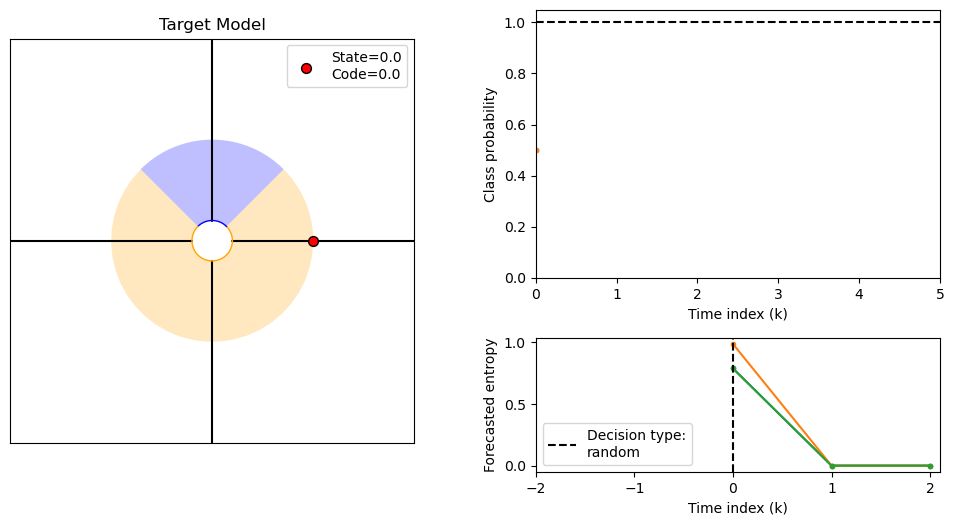

In [68]:
trial_params['trial_num'] = 0
trial_params['num_trials'] = 10

while trial_params['trial_num'] < trial_params['num_trials']:
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 4], wspace=0.3) 
    gs_signals = gridspec.GridSpecFromSubplotSpec(
        2, 1, height_ratios=[2,1], subplot_spec=gs[0, 1], hspace=0.3)
    def update(time_ind):
        ax_grid = plt.subplot(gs[0, 0])
        ax_diffusion = plt.subplot(gs_signals[0])
        ax_entropy = plt.subplot(gs_signals[1])
        ax_grid.cla()
        ax_diffusion.cla()
        ax_entropy.cla()

        current_angle = (across_trial_arrays['angles_visited_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), time_ind]%360)
        code_received = across_trial_arrays['codes_received_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), time_ind]
        initial_radians = np.radians(current_angle)

        setup_details = {'title': 'Target', 'grid_extent': 10, 
                            'inner_radius' : 1, 'outer_radius' : 5,
                            'agent_radians' : initial_radians}
        plot_code_dependent_regions(ax_grid, EMISSION_MATRIX_TARGETS[0], setup_details)
        plot_agent_in_env(ax_grid, setup_details, code_received)

        if time_ind>0:
            prev_angle = (across_trial_arrays['angles_visited_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), time_ind-1]%360)
            initial_radians = np.radians(prev_angle)
            ax_grid.scatter(1.2*setup_details['outer_radius']*np.cos(initial_radians), 1.2*setup_details['outer_radius']*np.sin(initial_radians),
                    s=200, marker='.', facecolor='r', edgecolor='k', alpha=0.6, zorder=4)
            
        if time_ind>1:
            prev_angle = (across_trial_arrays['angles_visited_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), time_ind-2]%360)
            initial_radians = np.radians(prev_angle)
            ax_grid.scatter(1.4*setup_details['outer_radius']*np.cos(initial_radians), 1.4*setup_details['outer_radius']*np.sin(initial_radians),
                    s=200, marker='.', facecolor='r', edgecolor='k', alpha=0.3, zorder=4)

        for i in range(NUM_BELIEFS):
            if i == 0:
                class_name = 'target'
            else:
                class_name = 'non-target'
            ax_diffusion.plot(across_trial_arrays['posterior_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), :time_ind+1][:,i], marker='.', label=f'Class {class_name}')
        ax_diffusion.axhline(y=1.0, linestyle='dashed', color='k')
        ax_diffusion.set_xlim(0, across_trial_arrays['time_taken_per_trial'][min(trial_params['trial_num'], trial_params['num_trials']-1)]+1)
        ax_diffusion.set_ylim(0.0, 1.05)
        ax_diffusion.set_xticks(np.arange(across_trial_arrays['time_taken_per_trial'][min(trial_params['trial_num'], trial_params['num_trials']-1)]+2).astype(int))
        ax_diffusion.set_ylabel('Class probability')
        ax_diffusion.set_xlabel('Time index (k)')

        x_vals = np.arange(max(0, time_ind-2), min(across_trial_arrays['expected_forecast_t_across_trials'].shape[1], time_ind+3)).astype(int)
        ax_entropy.plot(x_vals, across_trial_arrays['expected_forecast_t_across_trials'][min(trial_params['trial_num'], trial_params['num_trials']-1), max(0, time_ind-2):min(across_trial_arrays['expected_forecast_t_across_trials'].shape[1], time_ind+3)], 
                        marker='.')
        ax_entropy.axvline(x=time_ind, linestyle='dashed', color='k', label=f'Decision type:\n{across_trial_arrays["decision_type_across_trials"][min(trial_params['trial_num'], trial_params['num_trials']-1), time_ind]}')
        xlabels = np.arange(time_ind-2, min(across_trial_arrays['expected_forecast_t_across_trials'].shape[1], time_ind+3)).astype(int)
        ax_entropy.set_xticks(xlabels)
        ax_entropy.set_ylabel('Forecasted entropy')
        ax_entropy.legend(loc='lower left')
        ax_entropy.set_xlabel('Time index (k)')

    ani = animation.FuncAnimation(fig=fig, func=update, frames=int(across_trial_arrays['time_taken_per_trial'][min(trial_params['trial_num'], trial_params['num_trials']-1)]), interval=1500)
    ani.save(save_folder / f'trial_{min(trial_params['trial_num'], trial_params['num_trials']-1)}.gif')
    trial_params['trial_num'] +=1